# Análisis alrededor de eventos educativos para la prevención de accidentes con Minas Antipersonales (MAP)

Análisis exploratorio y estadístico de los eventos educativos así como el comportamiento en el número de casos antes, durante y despues de los mismos

## Dependencias

* Pandas
* Seaborn
* Matplotlib
* Swifter
* numpy
* math

## 1. Obtención y limpieza de los datos

In [1]:
#!wget 'https://www.datos.gov.co/api/views/4nyw-8qqq/rows.csv?accessType=DOWNLOAD' -O 'EducacionRiesgoMinas.csv'  &> /dev/null
#!wget 'https://www.datos.gov.co/api/views/sgp4-3e6k/rows.csv?accessType=DOWNLOAD' -O 'EventosMinas.csv' &> /dev/null
#!wget 'https://www.datos.gov.co/api/views/xdk5-pm3f/rows.csv?accessType=DOWNLOAD' -O 'MunicipiosDANE.csv' &> /dev/null

In [2]:
import pandas as pd

In [3]:
educacion  = pd.read_csv('EducacionRiesgoMinas.csv')
casos      = pd.read_csv('EventosMinas.csv')
municipios = pd.read_csv('MunicipiosDANE.csv')

In [4]:
educacion["FECHA_FINALIZACION"] = pd.to_datetime(educacion["FECHA_FINALIZACION"])
educacion["FECHA_INICIO"] = pd.to_datetime(educacion["FECHA_INICIO"], format="%m/%d/%Y %I:%M:%S %p", infer_datetime_format=False)   # 11/13/2019 12:00:00 AM    "%m/%d/%Y %I:%M:%S %p"
educacion["DURACION"] = educacion["FECHA_FINALIZACION"] - educacion["FECHA_INICIO"]
educacion["DURACION"] = educacion["DURACION"].apply(lambda x: x.days+1)
educacion = educacion[educacion["DURACION"] == 1]

## a. Funciones auxiliares

In [37]:
# date: month,year
def filterData(df, mun_dane_code=None, date=(None,None)):
  victimas = df
  month, year = date
  if month != None and year != None:
    victimas = victimas[(victimas["AÑO"]==year) & (victimas["MES"]==month)]
  if mun_dane_code != None:
    victimas = victimas[victimas["CODIGO_DANE_MUNICIPIO"] == mun_dane_code]
  victimas = victimas[victimas['TIPO_EVENTO'] == 'Accidente por MAP']
  return victimas


In [38]:
import math

# currentDate: month,year
def getPreviousDate(currentDate, nMonthsBefore):
  month, year = currentDate
  if nMonthsBefore < 0:
    nMonthsAfter = -nMonthsBefore
    month = month + nMonthsAfter
    newYear = year + math.floor(month / 12)
    newMonth = month % 12
    if newMonth == 0:
      return 12,newYear-1
  elif nMonthsBefore >= month:
    nYearsBefore = math.floor(nMonthsBefore / 12)
    #nMonthsBefore = nMonthsBefore - month
    nMonthsBefore = nMonthsBefore % 12
    newYear = year - nYearsBefore
    if nMonthsBefore >= month:
      newMonth = 12 - (nMonthsBefore - month)
      newYear = newYear - 1
    else:
      newMonth = month - nMonthsBefore
  else:
    newYear = year
    newMonth = month - nMonthsBefore
  return newMonth,newYear

# Descripción Datasets

__/!\__ Curiosamente hay muchos más casos que víctimas registradas (36899 vs 11892)

**<h2><center>Casos/Eventos</center></h2>**

* TIPO_EVENTO (Desminado, Accidente por MAP, Incautaciones,...)
* CODIGO_DANE_MUNICIPIO
* AÑO,MES

**Campos Descartados**

* DEPARTAMENTO, CODIGO_DANE_DEPARTAMENTO, MUNICIPIO, SITIO (Vereda)
* EVENTO (100% Nulo)
* TIPO_LUGAR (95% Nulo) TIPO_AREA (Rural,Urbana)
* UBICACIÓN, LATITUD_CABECERA, LONGITUD_CABECERA

In [39]:
casos.head()

,TIPO_EVENTO,DEPARTAMENTO,CODIGO_DANE_DEPARTAMENTO,MUNICIPIO,CODIGO_DANE_MUNICIPIO,AÑO,MES,EVENTO,TIPO_LUGAR,TIPO_AREA,LATITUD_CABECERA,LONGITUD_CABECERA,SITIO,UBICACION
0,Sospecha de campo minado,ANTIOQUIA,5,BRICEÑO,5107,2015,5,Sin información,En cerca a edificio residencial,Rural,7.099828,-75.658672,Camino a Chirí 2,POINT (-75.65867172 7.099828)
1,Accidente por MAP,ANTIOQUIA,5,YOLOMBÓ,5890,2002,1,Sin información,Sin informacion,Rural,6.730556,-75.062500,Vereda San Rafael,POINT (-75.0625 6.730556)
2,Accidente por MAP,CAQUETA,18,SAN VICENTE DEL CAGUÁN,18753,2008,10,Sin información,Sin informacion,Rural,2.169444,-74.783889,Platanillo,POINT (-74.78388889 2.169444444)
3,Accidente por MAP,CALDAS,17,RIOSUCIO,17614,2006,3,Sin información,Sin informacion,Rural,5.424265,-75.703599,Vereda La Sierra,POINT (-75.703599 5.424265)
4,Accidente por MAP,CESAR,20,SAN ALBERTO,20710,1996,4,Sin información,Sin informacion,Rural,7.763693,-73.396100,Sin información,POINT (-73.3961001 7.76369293)


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import swifter

In [41]:
def agregarCasosVictimas(df,nMonthsBefore):
  #getPreviousDate(currentDate, nMonthsBefore)
  colName = "CASOS_MES_" + str(nMonthsBefore)
  df[colName] = educacion.swifter.apply(lambda x: len(filterData(casos,x["CODIGO_DANE_MUNICIPIO"],getPreviousDate((x["FECHA_INICIO"].month,x["FECHA_INICIO"].year),nMonthsBefore))), axis=1)
  return df

In [42]:
edu = educacion
for i in range(4,-5,-1):
  print(i,"/",-4)
  edu = agregarCasosVictimas(edu,i)

4 / -4



3 / -4



2 / -4



1 / -4



0 / -4



-1 / -4



-2 / -4



-3 / -4



-4 / -4


In [43]:
def agregarTasaCrecimiento(df,n1,n2):
    n1, n2 = str(n1), str(n2)
    colName = "INCR_CASOS_" + n1 + "_" + n2
    col1 = "CASOS_MES_" + n1
    col2 = "CASOS_MES_" + n2
    df[colName] = df.swifter.apply(lambda x: (x[col2]-x[col1]), axis=1)
    return df

In [44]:
for month in range(-4,4):
    nextMonth = month+1
    edu = agregarTasaCrecimiento(edu,month,nextMonth)

### Remoción de registros sin casos

Antes de ejecutar el análisis estadístico se decidió remover los registros en los que había 0 casos en la ventana de tiempo del análisis (antes,durante y despues del evento) para analizar las correlaciones de crecimiento. 

In [45]:
pref = 'CASOS_MES_'
mask = (educacion['ORGANIZACIÓN'] == 'thisOrgDoesntExist')
for i in range(-4,4):
    col = pref + str(i)
    mask = mask | (edu[col] != 0)
edu = edu[mask]

## Análisis Estadístico

In [46]:
import pandas as _pd
import numpy as _np

from matplotlib import pyplot as plt
from matplotlib.collections import EllipseCollection
def plot_corr_ellipses(data, ax=None, **kwargs):

    M = _np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = _np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = _np.ones_like(M).ravel()
    h = 1 - _np.abs(M).ravel()
    a = 45 * _np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, _pd.DataFrame):
        ax.set_xticks(_np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(_np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


def corr_parcial(df, debug=True):
    S = LedoitWolf().fit(df).covariance_
    
    if debug == True:
        cond = np.linalg.cond(S) 
        print('N° cond:',cond)
        
    S_1 = _np.linalg.inv(S)
    diag_matrix_s_1_sqrt = _np.diag(1/_np.sqrt(_np.diag(S_1)))
    ones_mask=-_np.ones((len(S),len(S)))
    _np.fill_diagonal(ones_mask,_np.ones(len(S)))
    almost_P = diag_matrix_s_1_sqrt@S_1@diag_matrix_s_1_sqrt
    return _pd.DataFrame(_np.multiply(ones_mask,almost_P), columns = df.columns, index = df.columns)

def R_2(df):
  if isinstance(df, _pd.DataFrame):
    df = df.to_numpy()
  S = _np.cov(df, rowvar=False)
  S_inv = _np.linalg.inv(S)
  return 1 - (1/(_np.diag(S)*_np.diag(S_inv)))

In [47]:
cols = [
    'CASOS_MES_-4','CASOS_MES_-3','CASOS_MES_-2','CASOS_MES_-1',
    'CASOS_MES_0','CASOS_MES_1','CASOS_MES_2','CASOS_MES_3','CASOS_MES_4',
      ]
edu_casos = edu[cols]
r2_casos = R_2(edu_casos)
corr_casos = edu_casos.corr()

In [48]:
cols = [
    'INCR_CASOS_-4_-3','INCR_CASOS_-3_-2','INCR_CASOS_-2_-1','INCR_CASOS_-1_0',
    'INCR_CASOS_0_1','INCR_CASOS_1_2','INCR_CASOS_2_3','INCR_CASOS_3_4'
      ]
edu_increm_casos = edu[cols]
r2_increm_casos = R_2(edu_increm_casos)
corr_increm_casos = edu_increm_casos.corr()

In [49]:
from sklearn.covariance import LedoitWolf

### I. Correlación simple del n° de casos de MAP antes, durante y después del mes del evento educativo

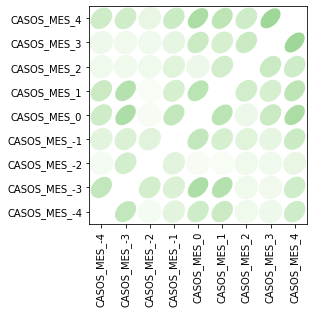

In [50]:
_ = plot_corr_ellipses(corr_casos,cmap='Greens')

### II. Correlación parcial del n° de casos de MAP antes, durante y después del mes del evento educativo

In [51]:
np.linalg.det(corr_casos)

0.33679991104975493

In [52]:
partial_corr_casos = corr_parcial(edu_casos)

N° cond: 4.67490601010215


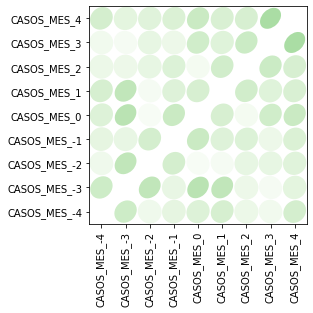

In [53]:
plot_corr_ellipses(partial_corr_casos, cmap='Greens')

### III. Correlación simple del incremento en el n° de casos de MAP antes, durante y después del mes del evento educativo

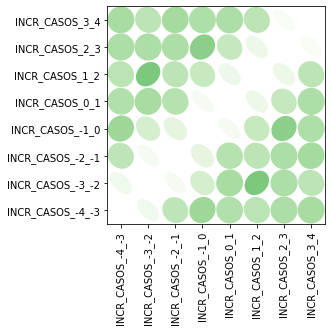

In [54]:
_ = plot_corr_ellipses(corr_increm_casos,cmap='Greens')

### IV. Correlación parcial del incremento en el n° de casos de MAP antes, durante y después del mes del evento educativo

In [55]:
np.linalg.det(corr_increm_casos)

0.04787163271714319

In [56]:
partial_corr_increm = corr_parcial(edu_increm_casos)

N° cond: 18.278298255359186


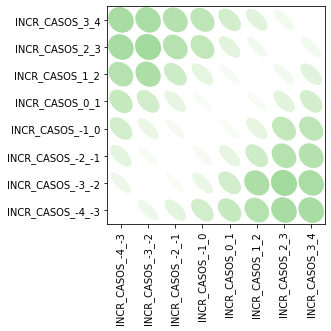

In [57]:
plot_corr_ellipses(partial_corr_increm, cmap='Greens')

### V. Analisis de los R²

In [58]:
r2_casos

array([0.12952476, 0.23357138, 0.077286  , 0.13178661, 0.26039478,
       0.21359497, 0.11111965, 0.20171829, 0.28293515])

In [59]:
r2_increm_casos

array([0.42889684, 0.67924768, 0.69367683, 0.72604001, 0.72934014,
       0.6830501 , 0.61762942, 0.46999352])

# Análisis de los resultados obtenidos

In [60]:
def analizeIncrement(edu,periodA,periodB,debug=False):
    prefix = 'INCR_CASOS_'
    fieldA,fieldB = prefix + periodA, prefix + periodB
    n_greater = len(edu[edu[fieldA] >  edu[fieldB]])
    n_lower   = len(edu[edu[fieldA] <  edu[fieldB]])
    n_equal   = len(edu[edu[fieldA] == edu[fieldB]])
    if debug == True:
        print('Analisis Incremento:',periodA,'-', periodB)
        print('\t <<< ',n_greater,'\t >>> ',n_lower,'\t===',n_equal)
    return n_greater, n_lower, n_equal

In [61]:
def analizeNumberOfCases(edu,periodA,periodB,debug=False):
    prefix = 'CASOS_MES_'
    fieldA,fieldB = prefix + periodA, prefix + periodB
    n_greater = len(edu[edu[fieldA] >  edu[fieldB]])
    n_lower   = len(edu[edu[fieldA] <  edu[fieldB]])
    n_equal   = len(edu[edu[fieldA] == edu[fieldB]])
    if debug == True:
        print('Analisis N° Casos:',periodA,'-', periodB)
        print('\t <<< ',n_greater,'\t >>> ',n_lower,'\t===',n_equal)
    return n_greater, n_lower, n_equal

In [62]:
data = educacion
pref = 'CASOS_MES_'
mask = (data['ORGANIZACIÓN'] == 'thisOrgDoesntExist')
for i in range(-4,4):
    col = pref + str(i)
    mask = mask | (data[col] != 0)
data = data[mask]

In [63]:
data

,ID_ERM,DEPARTAMENTO,CODIGO_DANE_DEPARTAMENTO,MUNICIPIO,CODIGO_DANE_MUNICIPIO,ORGANIZACIÓN,MOTIVO_ACTIVIDAD,FECHA_INICIO,AÑO,FECHA_FINALIZACION,...,CASOS_MES_-3,CASOS_MES_-4,INCR_CASOS_-4_-3,INCR_CASOS_-3_-2,INCR_CASOS_-2_-1,INCR_CASOS_-1_0,INCR_CASOS_0_1,INCR_CASOS_1_2,INCR_CASOS_2_3,INCR_CASOS_3_4
36,ERM_ACT_280,ANTIOQUIA,5,VALDIVIA,5854,Campaña Colombiana Contra Minas,Sin especificar,2017-05-19,2017,2017-05-19,...,0,0,0,0,0,0,0,0,1,-1
123,ERM_ACT_306,ANTIOQUIA,5,DABEIBA,5234,Campaña Colombiana Contra Minas,Sin especificar,2017-09-05,2017,2017-09-05,...,1,0,1,-1,0,0,0,0,0,0
235,ERM_ACT_865,SUCRE,70,CHALÁN,70230,Organización de los Estados Americanos,Sin especificar,2016-07-21,2016,2016-07-21,...,1,0,1,-1,0,0,0,0,0,0
427,ERM_ACT_1068,SUCRE,70,CHALÁN,70230,Organización de los Estados Americanos,Sin especificar,2016-11-14,2016,2016-11-14,...,0,0,0,0,0,0,1,-1,0,0
428,ERM_ACT_1069,SUCRE,70,CHALÁN,70230,Organización de los Estados Americanos,Sin especificar,2016-11-14,2016,2016-11-14,...,0,0,0,0,0,0,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17476,ERM_ACT_54728,NARIÑO,52,TUMACO,52835,CORPORACION PAZ Y DEMOCRACIA,Sin especificar,2018-11-26,2018,2018-11-26,...,4,2,2,-4,1,3,-1,-3,1,1
17477,ERM_ACT_54696,NARIÑO,52,TUMACO,52835,CORPORACION PAZ Y DEMOCRACIA,Sin especificar,2018-11-26,2018,2018-11-26,...,4,2,2,-4,1,3,-1,-3,1,1
17479,ERM_ACT_54707,NARIÑO,52,TUMACO,52835,CORPORACION PAZ Y DEMOCRACIA,Sin especificar,2019-05-13,2019,2019-05-13,...,0,0,0,0,0,0,3,-1,2,-4
17480,ERM_ACT_54708,NARIÑO,52,TUMACO,52835,CORPORACION PAZ Y DEMOCRACIA,Sin especificar,2019-05-14,2019,2019-05-14,...,0,0,0,0,0,0,3,-1,2,-4


In [64]:
for i in range(-4,3):
    a = str(i) + '_' + str(i+1)
    b = str(i+1) + '_' + str(i+2)
    _ = analizeIncrement(data,a,b,debug=True)

Analisis Incremento: -4_-3 - -3_-2
	 <<<  491 	 >>>  728 	=== 1728
Analisis Incremento: -3_-2 - -2_-1
	 <<<  633 	 >>>  764 	=== 1550
Analisis Incremento: -2_-1 - -1_0
	 <<<  503 	 >>>  1043 	=== 1401
Analisis Incremento: -1_0 - 0_1
	 <<<  590 	 >>>  913 	=== 1444
Analisis Incremento: 0_1 - 1_2
	 <<<  631 	 >>>  866 	=== 1450
Analisis Incremento: 1_2 - 2_3
	 <<<  518 	 >>>  962 	=== 1467
Analisis Incremento: 2_3 - 3_4
	 <<<  530 	 >>>  631 	=== 1786


In [65]:
for i in range(-4,3):
    a = str(i)
    b = str(i+1)
    _ = analizeNumberOfCases(data,a,b,debug=True)

Analisis N° Casos: -4 - -3
	 <<<  394 	 >>>  680 	=== 1873
Analisis N° Casos: -3 - -2
	 <<<  440 	 >>>  646 	=== 1861
Analisis N° Casos: -2 - -1
	 <<<  593 	 >>>  534 	=== 1820
Analisis N° Casos: -1 - 0
	 <<<  484 	 >>>  582 	=== 1881
Analisis N° Casos: 0 - 1
	 <<<  562 	 >>>  587 	=== 1798
Analisis N° Casos: 1 - 2
	 <<<  601 	 >>>  542 	=== 1804
Analisis N° Casos: 2 - 3
	 <<<  502 	 >>>  597 	=== 1848


In [36]:
casos['TIPO_EVENTO'] == 'Accidente por MAP'

0        False
1         True
2         True
3         True
4         True
         ...  
36894    False
36895    False
36896    False
36897    False
36898    False
Name: TIPO_EVENTO, Length: 36899, dtype: bool